# Pipeline Principal: Fusión de Imágenes y Medición

Este notebook implementa el pipeline completo para fusionar las tres imágenes del comedor en un panorama coherente, calibrar el sistema y realizar mediciones.

## Objetivos

1. Cargar las tres imágenes originales
2. Detectar características y establecer correspondencias
3. Estimar homografías robustas con RANSAC
4. Fusionar imágenes con técnicas de blending
5. Calibrar el sistema usando objetos de referencia
6. Medir dimensiones de elementos en la escena
7. Analizar incertidumbre en las mediciones


In [16]:
# Importar librerías
import sys
sys.path.append('..')

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd

# Importar módulos propios
from src import utils
from src.feature_detection import FeatureDetector, DetectorType
from src.matching import FeatureMatcher, MatcherType, get_matched_points
from src.registration import (
    ImageStitcher, 
    estimate_homography, 
    warp_image,
    refine_homography,
    validate_homography,
    compute_reprojection_error
)
from src.measurement import Calibrator, InteractiveMeasurementTool, measure_distance_simple

# Configuración
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10
np.set_printoptions(precision=4, suppress=True)

print("Librerías importadas correctamente")


Librerías importadas correctamente


## 1. Cargar Imágenes del Comedor

Cargamos las tres imágenes originales del comedor.


Imágenes encontradas: 3
  IMG01.jpg: (4032, 3024, 3)
  IMG02.jpg: (4032, 3024, 3)
  IMG03.jpg: (3024, 4032, 3)


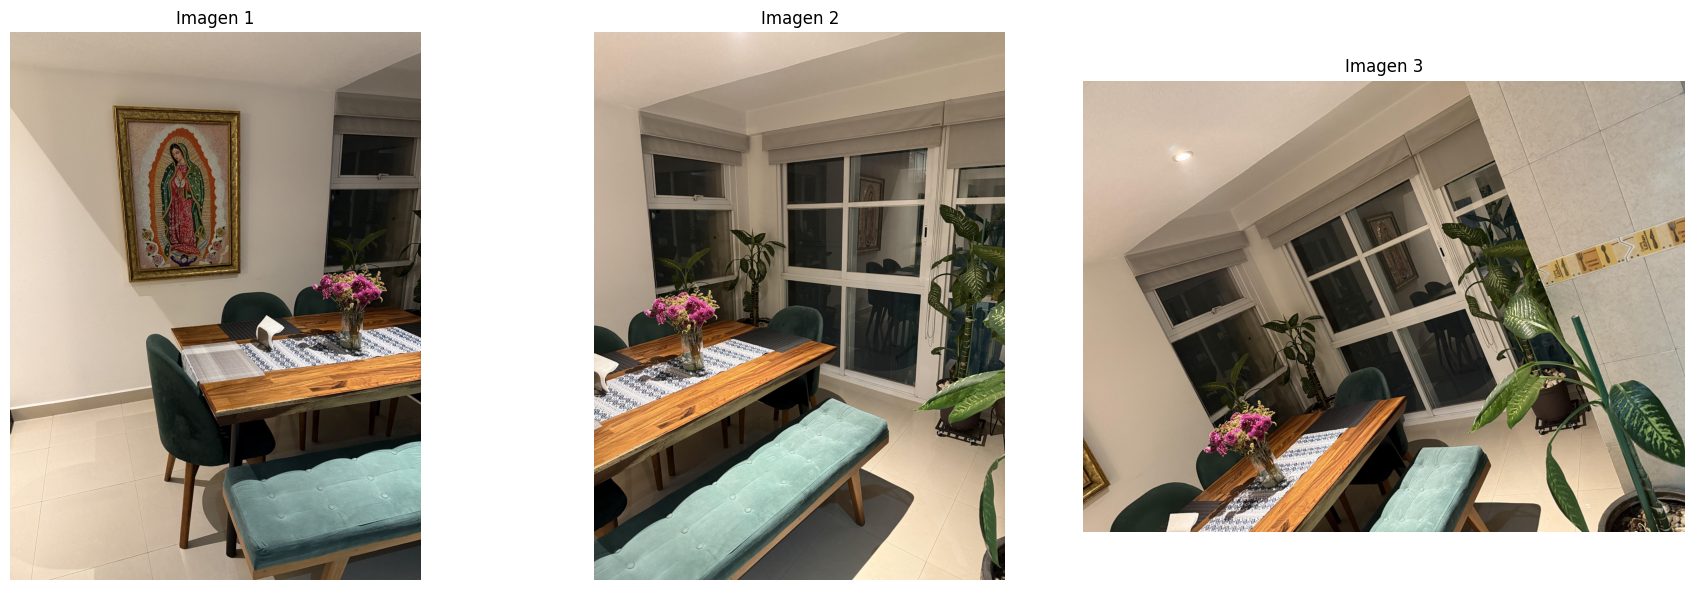

In [17]:
# Cargar imágenes
image_dir = Path('../data/original')
image_paths = sorted(list(image_dir.glob('*.jpg')))

print(f"Imágenes encontradas: {len(image_paths)}")

images = []
for path in image_paths:
    img = utils.load_image(str(path))
    images.append(img)
    print(f"  {path.name}: {img.shape}")

# Visualizar
utils.visualize_images(
    images,
    titles=[f'Imagen {i+1}' for i in range(len(images))],
    figsize=(18, 6)
)


## 2. Detección de Características

Detectamos características en todas las imágenes usando SIFT.


In [18]:
# Usar SIFT como detector principal
detector = FeatureDetector(DetectorType.SIFT)

print("Detectando características...")
all_keypoints = []
all_descriptors = []

for i, img in enumerate(images):
    kp, desc = detector.detect_and_compute(img)
    all_keypoints.append(kp)
    all_descriptors.append(desc)
    print(f"  Imagen {i+1}: {len(kp)} keypoints")


Detectando características...
  Imagen 1: 61930 keypoints
  Imagen 2: 37273 keypoints
  Imagen 3: 33332 keypoints


## 3. Emparejamiento de Características

Establecemos correspondencias entre imágenes consecutivas.


In [19]:
# Matcher
matcher = FeatureMatcher(MatcherType.BF, descriptor_type='SIFT')

print("Emparejando características...")
matches_data = []

for i in range(len(images) - 1):
    print(f"\n  Par {i+1}-{i+2}:")
    
    # Match robusto
    matches = matcher.match_robust(all_descriptors[i], all_descriptors[i+1], ratio=0.75)
    points1, points2 = get_matched_points(all_keypoints[i], all_keypoints[i+1], matches)
    
    print(f"    Matches: {len(matches)}")
    print(f"    Puntos extraídos: {len(points1)}")
    
    matches_data.append({
        'matches': matches,
        'points1': points1,
        'points2': points2
    })


Emparejando características...

  Par 1-2:
    Matches: 5795
    Puntos extraídos: 5795

  Par 2-3:
    Matches: 6129
    Puntos extraídos: 6129


## 4. Fusión de Imágenes (Stitching)

Usamos ImageStitcher para fusionar las imágenes en un panorama coherente.


In [20]:
# Crear stitcher con blending feather (transiciones suaves)
stitcher = ImageStitcher(blend_method='feather')

# Estimar transformaciones
print("Estimando homografías...")
reference_idx = 1  # Usar imagen central como referencia

success = stitcher.estimate_transforms(images, matches_data, reference_idx=reference_idx)

if success:
    print(" Homografías estimadas correctamente")
    
    # Mostrar homografías
    for i, H in enumerate(stitcher.homographies):
        if H is not None:
            print(f"\nHomografía imagen {i} a referencia:")
            print(H)
else:
    print(" Error al estimar homografías")
    raise Exception("No se pudieron estimar las homografías")


Estimando homografías...
 Homografías estimadas correctamente

Homografía imagen 0 a referencia:
[[    1.4826     0.1008 -2971.694 ]
 [    0.311      1.052     68.8174]
 [    0.0003    -0.0001     1.    ]]

Homografía imagen 1 a referencia:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Homografía imagen 2 a referencia:
[[   0.8459   -0.3042  380.124 ]
 [   0.3218    0.7565 -267.1102]
 [  -0.       -0.        1.    ]]



Fusionando imágenes...
Tamaño del panorama: 9707x9429
Procesando imagen 1/3...
Procesando imagen 2/3...
Procesando imagen 3/3...
 Panorama creado: (9429, 9707, 3)


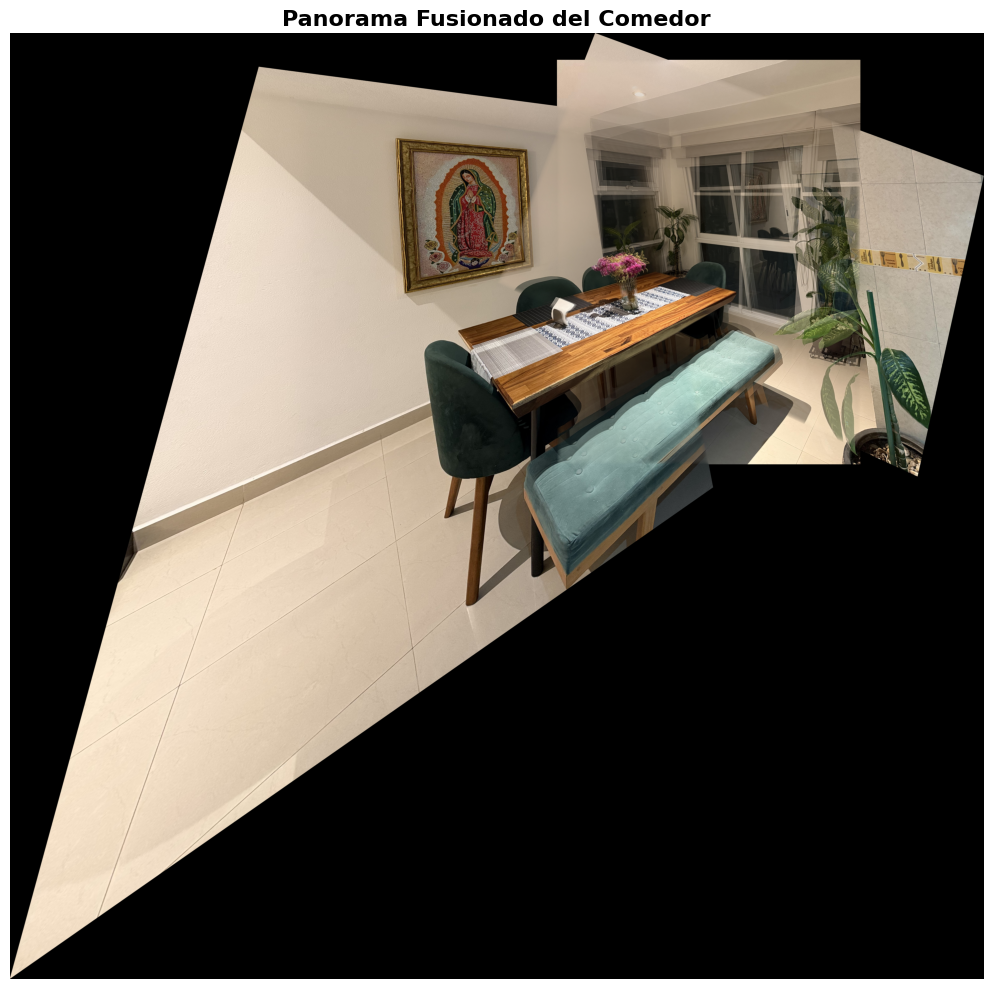

In [21]:
# Fusionar imágenes
print("\nFusionando imágenes...")
panorama = stitcher.stitch(images)

print(f" Panorama creado: {panorama.shape}")

# Visualizar resultado
plt.figure(figsize=(20, 10))
plt.imshow(panorama)
plt.title('Panorama Fusionado del Comedor', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig('../results/figures/08_panorama_final.png', dpi=300, bbox_inches='tight')
plt.show()

# Guardar panorama
utils.save_image(panorama, '../results/panorama_comedor.png')


En esta imagen, se puede ver que la fusión entre la IMG02 y la IMG03 no fue buena. Esto es seguramente debido a un fuerte efecto de paralaje: la cámara se movió de lado (traslación) entre las fotos, no solo rotó. Por esto, los objetos cercanos como la planta grande se desalinearon drásticamente con respecto al fondo (la pared y las ventanas).

El algoritmo de homografía no supo cómo resolver este conflicto entre el primer plano y el fondo, así que colapsó y generó una transformación incorrecta.

Para solucionarlo, la estrategia será seleccionar puntos **manuales** de correspondencia únicamente en el plano del fondo. Al forzar al algoritmo a alinear solo con estas esquinas de las ventanas y el reflejo, ignorando la planta, se debería poder calcular una homografía estable que una la escena de forma coherente.

<p align="center">
    <img src="imgs_md/manual_points.png" alt="Manual points FIJI" width="600">
</p>


FUSIÓN MEJORADA: Manual (IMG02+IMG03) → Automático (IMG01 + panorama)
PASO 1: Fusión IMG02 + IMG03 con puntos manuales

1.1. Cargando puntos manuales para IMG02-IMG03...
 Puntos manuales cargados: 12 puntos correspondientes

1.2. Estimando homografía para IMG02-IMG03 con puntos manuales...
   Inliers: 5/12 (41.7%)
   Error de reproyección: 0.26 píxeles

1.3. Creando panorama parcial IMG02+IMG03...
Tamaño del panorama: 5648x4821
Procesando imagen 1/2...
Procesando imagen 2/2...
   Panorama parcial creado: (4821, 5648, 3)


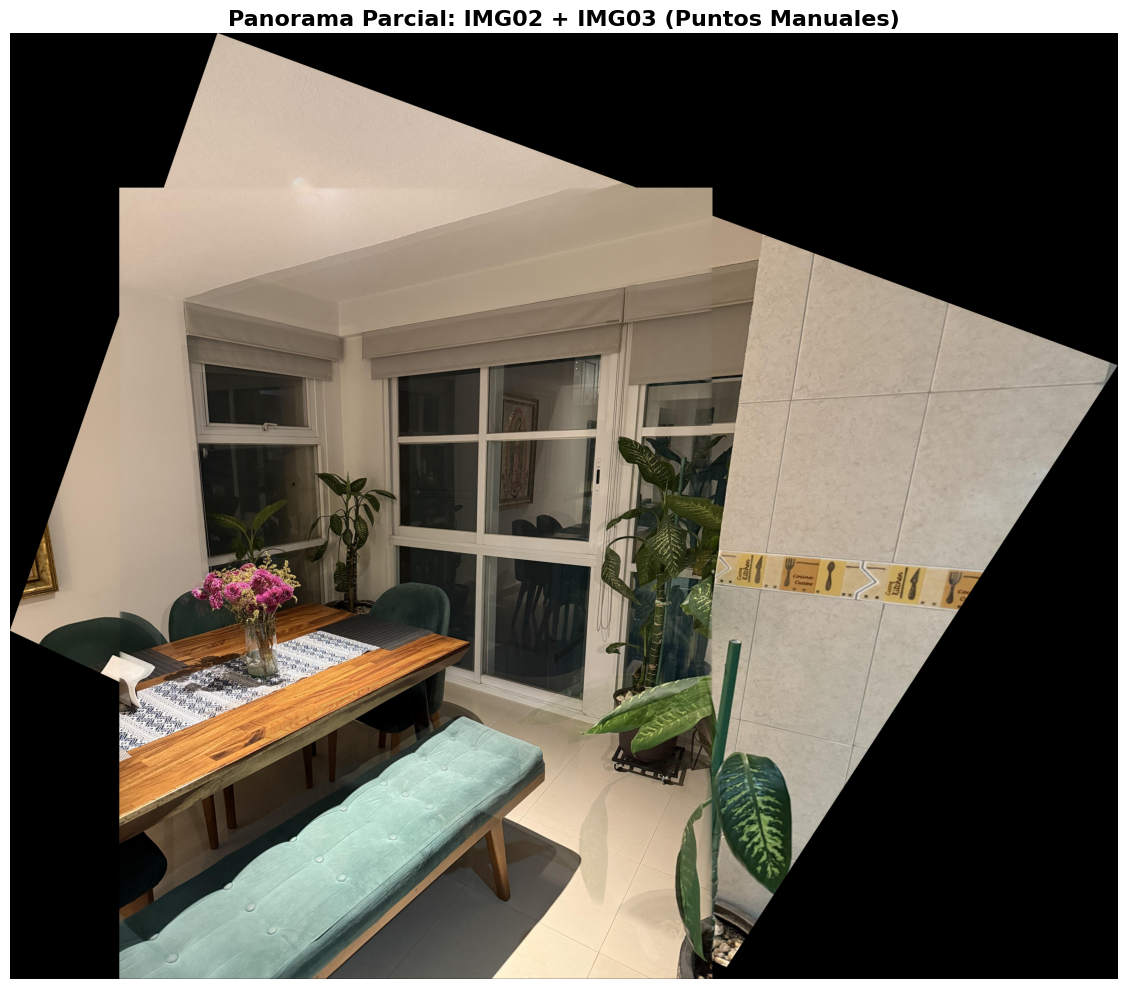

PASO 2: Fusión IMG01 + Panorama Parcial con puntos automáticos

2.1. Detectando características en IMG01 y panorama parcial...
   IMG01: 61930 keypoints
   Panorama parcial: 37157 keypoints

2.2. Emparejando características automáticamente...
   Matches encontrados: 4916
   Puntos extraídos: 4916

2.3. Estimando homografía automática...
   Inliers: 2949/4916 (60.0%)
   Error de reproyección: 0.78 píxeles

2.4. Creando estructura de matches para fusión final...

2.5. Fusionando IMG01 con panorama parcial...
Tamaño del panorama: 9451x8931
Procesando imagen 1/2...
Procesando imagen 2/2...
   Panorama final creado: (8931, 9451, 3)


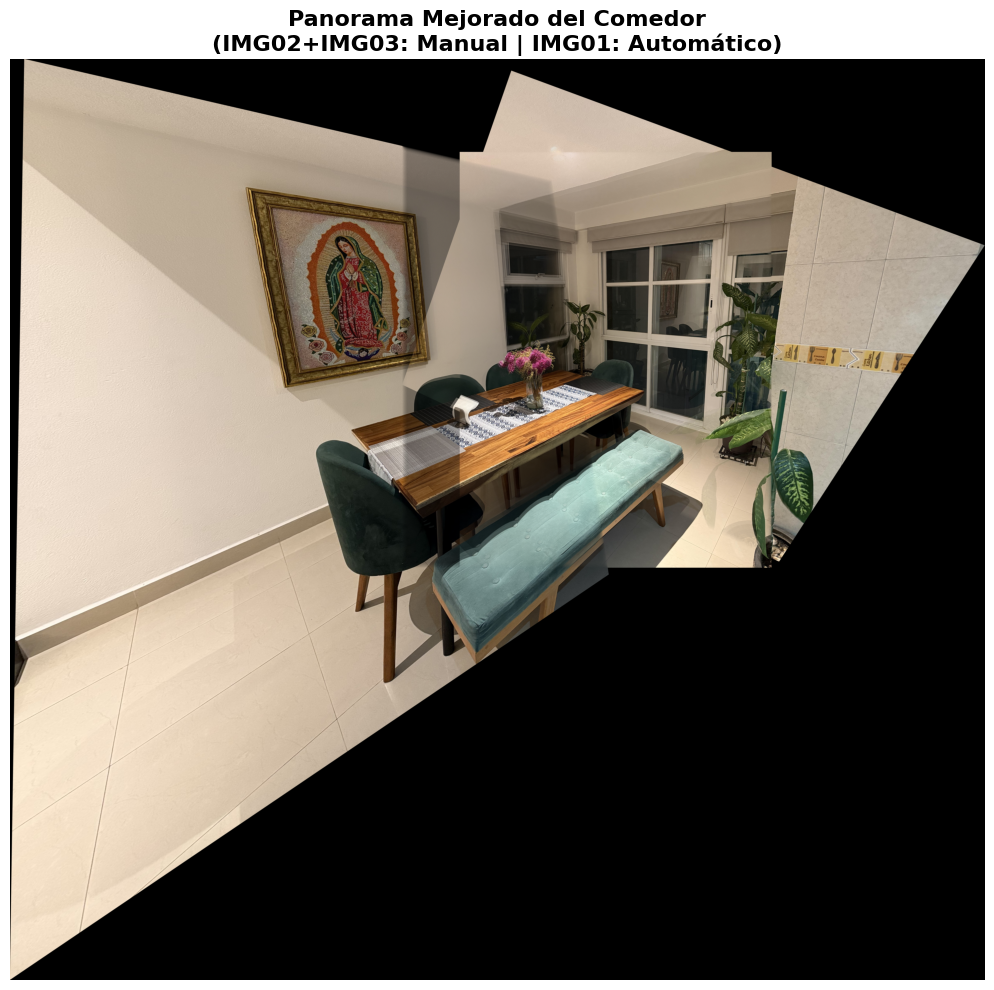

In [22]:
# Fusión mejorada: primero IMG02+IMG03 con puntos manuales, luego IMG01 con el resultado usando automático

def load_manual_points(points1_path: str, points2_path: str):
    """
    Carga puntos correspondientes desde archivos de texto.
    
    Args:
        points1_path: Ruta al archivo con puntos de IMG02
        points2_path: Ruta al archivo con puntos de IMG03
        
    Returns:
        Tupla (points_fija, points_movil) o (None, None) si falla
    """
    def parse_points_file(filepath):
        """Lee puntos desde un archivo de texto (formato: x y en cada línea)."""
        points = []
        try:
            with open(filepath, 'r') as f:
                for line in f:
                    line = line.strip()
                    if line and not line.startswith('#'):
                        parts = line.split()
                        if len(parts) >= 2:
                            try:
                                x = float(parts[0])
                                y = float(parts[1])
                                points.append([x, y])
                            except ValueError:
                                continue
        except Exception as e:
            print(f"Error al leer archivo {filepath}: {e}")
            return None
        
        if len(points) == 0:
            return None
        return np.array(points, dtype=np.float32)
    
    points_fija = parse_points_file(points1_path)
    points_movil = parse_points_file(points2_path)
    
    if points_fija is None or points_movil is None:
        print("Error: No se pudieron cargar los puntos")
        return None, None
    
    if len(points_fija) != len(points_movil):
        print(f"Advertencia: Número diferente de puntos ({len(points_fija)} vs {len(points_movil)})")
        n = min(len(points_fija), len(points_movil))
        points_fija = points_fija[:n]
        points_movil = points_movil[:n]
    
    if len(points_fija) < 4:
        print(f"Error: Se necesitan al menos 4 puntos, se encontraron {len(points_fija)}")
        return None, None
    
    print(f" Puntos manuales cargados: {len(points_fija)} puntos correspondientes")
    return points_fija, points_movil

print("FUSIÓN MEJORADA: Manual (IMG02+IMG03) → Automático (IMG01 + panorama)")

# PASO 1: Fusionar IMG02 + IMG03 usando puntos manuales
print("PASO 1: Fusión IMG02 + IMG03 con puntos manuales")

# 1.1 Cargar puntos manuales para IMG02-IMG03
print("\n1.1. Cargando puntos manuales para IMG02-IMG03...")
data_dir = Path('../data/original')
points1_path = data_dir / "IMG02_03.txt"
points2_path = data_dir / "IMG03_02.txt"

points_img02, points_img03 = load_manual_points(str(points1_path), str(points2_path))

if points_img02 is None or points_img03 is None:
    raise Exception("No se pudieron cargar los puntos manuales para IMG02-IMG03")

# 1.2 Estimar homografía para IMG02-IMG03 usando puntos manuales
print("\n1.2. Estimando homografía para IMG02-IMG03 con puntos manuales...")
H_manual, mask_manual = estimate_homography(
    points_img03,  # puntos móviles (IMG03)
    points_img02,  # puntos fijos (IMG02)
    ransac_threshold=3.0,
    confidence=0.99,
    max_iters=2000
)

if H_manual is None:
    raise Exception("No se pudo estimar la homografía con puntos manuales")

n_inliers = np.sum(mask_manual) if mask_manual is not None else len(points_img03)
print(f"   Inliers: {n_inliers}/{len(points_img03)} ({100*n_inliers/len(points_img03):.1f}%)")

# Validar y refinar homografía
if not validate_homography(H_manual, images[2].shape):
    raise Exception("Homografía manual no válida")

H_manual_refined = refine_homography(H_manual, points_img03, points_img02, mask_manual)

# Calcular error de reproyección
inliers_movil = points_img03[mask_manual.ravel() == 1] if mask_manual is not None else points_img03
inliers_fija = points_img02[mask_manual.ravel() == 1] if mask_manual is not None else points_img02
reproj_error = compute_reprojection_error(inliers_movil, inliers_fija, H_manual_refined)
print(f"   Error de reproyección: {reproj_error:.2f} píxeles")

# 1.3 Crear estructura de matches para IMG02-IMG03
print("\n1.3. Creando panorama parcial IMG02+IMG03...")
class FakeKeypoint:
    def __init__(self, x, y):
        self.pt = (float(x), float(y))

class FakeMatch:
    def __init__(self, query_idx, train_idx):
        self.queryIdx = query_idx
        self.trainIdx = train_idx

fake_kp2 = [FakeKeypoint(p[0], p[1]) for p in points_img02]
fake_kp3 = [FakeKeypoint(p[0], p[1]) for p in points_img03]
fake_matches_manual = [FakeMatch(i, i) for i in range(len(points_img02))]

matches_data_manual = [{
    'matches': fake_matches_manual,
    'points1': points_img02,  # IMG02 (referencia)
    'points2': points_img03    # IMG03
}]

# Crear stitcher para IMG02+IMG03
stitcher_manual = ImageStitcher(
    blend_method='feather',
    image_weights=[7.0, 1.0]  # IMG02 tiene más peso que IMG03
)

success = stitcher_manual.estimate_transforms(
    [images[1], images[2]],  # Solo IMG02 e IMG03
    matches_data_manual,
    reference_idx=0  # IMG02 como referencia
)

if not success:
    raise Exception("No se pudieron estimar las transformaciones para IMG02-IMG03")

# Crear panorama parcial IMG02+IMG03
panorama_parcial = stitcher_manual.stitch([images[1], images[2]])
print(f"   Panorama parcial creado: {panorama_parcial.shape}")

# Visualizar panorama parcial
plt.figure(figsize=(20, 10))
plt.imshow(panorama_parcial)
plt.title('Panorama Parcial: IMG02 + IMG03 (Puntos Manuales)', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig('../results/figures/panorama_parcial_IMG02_IMG03.png', dpi=300, bbox_inches='tight')
plt.show()

# PASO 2: Fusionar IMG01 con el panorama parcial usando puntos automáticos
print("PASO 2: Fusión IMG01 + Panorama Parcial con puntos automáticos")

# 2.1 Detectar características en IMG01 y panorama parcial
print("\n2.1. Detectando características en IMG01 y panorama parcial...")
kp_img01, desc_img01 = detector.detect_and_compute(images[0])
kp_panorama, desc_panorama = detector.detect_and_compute(panorama_parcial)

print(f"   IMG01: {len(kp_img01)} keypoints")
print(f"   Panorama parcial: {len(kp_panorama)} keypoints")

# 2.2 Emparejar características automáticamente
print("\n2.2. Emparejando características automáticamente...")
matches_auto = matcher.match_robust(desc_img01, desc_panorama, ratio=0.75)
points_img01, points_panorama = get_matched_points(kp_img01, kp_panorama, matches_auto)

print(f"   Matches encontrados: {len(matches_auto)}")
print(f"   Puntos extraídos: {len(points_img01)}")

if len(points_img01) < 4:
    raise Exception(f"No se encontraron suficientes correspondencias automáticas: {len(points_img01)}")

# 2.3 Estimar homografía automática
print("\n2.3. Estimando homografía automática...")
H_auto, mask_auto = estimate_homography(
    points_img01,      # puntos móviles (IMG01)
    points_panorama,  # puntos fijos (panorama parcial)
    ransac_threshold=3.0,
    confidence=0.995,
    max_iters=2000
)

if H_auto is None:
    raise Exception("No se pudo estimar la homografía automática")

n_inliers_auto = np.sum(mask_auto) if mask_auto is not None else len(points_img01)
print(f"   Inliers: {n_inliers_auto}/{len(points_img01)} ({100*n_inliers_auto/len(points_img01):.1f}%)")

# Validar y refinar homografía
if not validate_homography(H_auto, images[0].shape):
    raise Exception("Homografía automática no válida")

H_auto_refined = refine_homography(H_auto, points_img01, points_panorama, mask_auto)

# Calcular error de reproyección
inliers_img01 = points_img01[mask_auto.ravel() == 1] if mask_auto is not None else points_img01
inliers_panorama = points_panorama[mask_auto.ravel() == 1] if mask_auto is not None else points_panorama
reproj_error_auto = compute_reprojection_error(inliers_img01, inliers_panorama, H_auto_refined)
print(f"   Error de reproyección: {reproj_error_auto:.2f} píxeles")

# 2.4 Crear estructura de matches para la fusión final
print("\n2.4. Creando estructura de matches para fusión final...")
fake_kp_img01 = [FakeKeypoint(p[0], p[1]) for p in points_img01]
fake_kp_panorama = [FakeKeypoint(p[0], p[1]) for p in points_panorama]
fake_matches_auto = [FakeMatch(i, i) for i in range(len(points_img01))]

matches_data_final = [{
    'matches': fake_matches_auto,
    'points1': points_panorama,  # Panorama parcial (referencia)
    'points2': points_img01      # IMG01
}]

# 2.5 Fusionar IMG01 con panorama parcial
print("\n2.5. Fusionando IMG01 con panorama parcial...")
stitcher_final = ImageStitcher(
    blend_method='feather',
    image_weights=[1.0, 2.0] 
)

success_final = stitcher_final.estimate_transforms(
    [panorama_parcial, images[0]],  # Panorama parcial primero, luego IMG01
    matches_data_final,
    reference_idx=0  # Panorama parcial como referencia
)

if not success_final:
    raise Exception("No se pudieron estimar las transformaciones finales")

# Crear panorama final
panorama_improved = stitcher_final.stitch([panorama_parcial, images[0]])
print(f"   Panorama final creado: {panorama_improved.shape}")

# RESULTADO FINAL

# Visualizar resultado final
plt.figure(figsize=(20, 10))
plt.imshow(panorama_improved)
plt.title('Panorama Mejorado del Comedor\n(IMG02+IMG03: Manual | IMG01: Automático)', 
          fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig('../results/figures/08_panorama_final_improved.png', dpi=300, bbox_inches='tight')
plt.show()

# Guardar panorama mejorado
utils.save_image(panorama_improved, '../results/panorama_comedor_improved.png')

panorama_auto = panorama.copy()

# Actualizar variable panorama para usar en siguientes celdas
panorama = panorama_improved




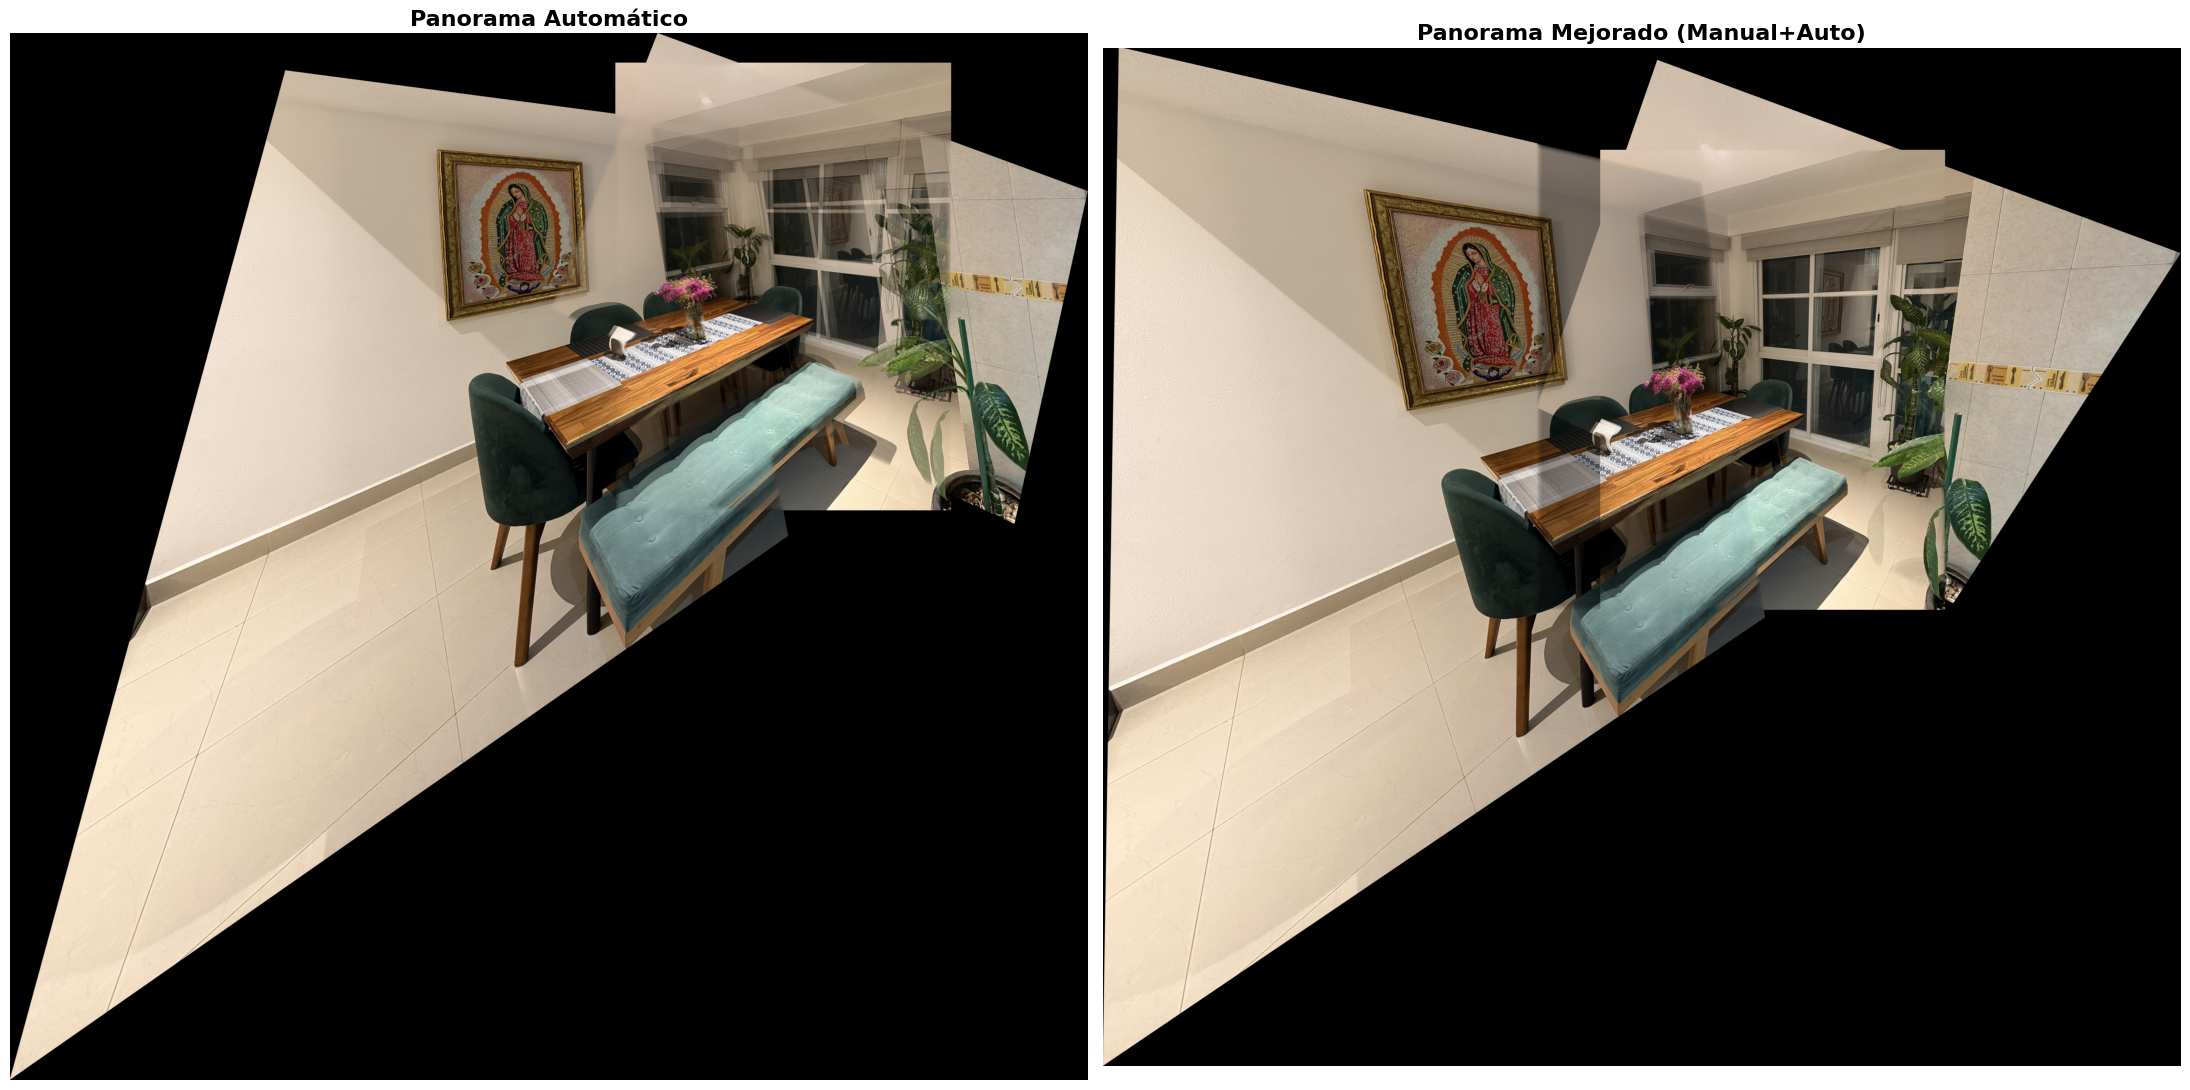

In [23]:
# Comparar visualmente el panorama automático y el mejorado

fig, axes = plt.subplots(1, 2, figsize=(22, 14))

axes[0].imshow(panorama_auto)
axes[0].set_title('Panorama Automático', fontsize=16, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(panorama_improved)
axes[1].set_title('Panorama Mejorado (Manual+Auto)', fontsize=16, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.savefig('../results/figures/09_comparacion_panorama_auto_vs_mejorado.png', dpi=300, bbox_inches='tight')
plt.show()


## 5. Calibración del Sistema

Calibramos usando las dimensiones conocidas de objetos de referencia:
- **Cuadro de la Virgen de Guadalupe**: 117 cm de altura
- **Mesa**: 161.1 cm de ancho


In [24]:
# Crear calibrador
calibrator = Calibrator()

# Ejemplo: Medir el cuadro de la Virgen de Guadalupe (altura = 117 cm)
# El usuario debe identificar la parte superior e inferior del cuadro

print("CALIBRACIÓN - Paso 1: Cuadro de la Virgen de Guadalupe")

print("Identificar dos puntos verticales del cuadro:")
print("  - Punto superior del cuadro")
print("  - Punto inferior del cuadro")
print("\nActualizar las coordenadas en este código.\n")

# Coordenadas del cuadro de la Virgen de Guadalupe
cuadro_punto_superior = (2292, 1242)  # (x, y)
cuadro_punto_inferior = (2665, 3190)  # (x, y)

# Calcular distancia en píxeles
cuadro_altura_pixeles = np.linalg.norm(
    np.array(cuadro_punto_superior) - np.array(cuadro_punto_inferior)
)

print(f"Altura del cuadro en píxeles: {cuadro_altura_pixeles:.2f}")
print(f"Altura real del cuadro: 117 cm")

# Agregar al calibrador
calibrator.add_reference_object(
    name="Cuadro Virgen de Guadalupe",
    pixel_length=cuadro_altura_pixeles,
    real_length_cm=117.0
)


print("CALIBRACIÓN - Paso 2: Mesa (ancho)")

print("Identificar dos puntos horizontales de la mesa:")
print("  - Punto izquierdo de la mesa")
print("  - Punto derecho de la mesa")
print("\nActualizar las coordenadas en este código.\n")

# Coordenadas de la mesa
mesa_punto_izquierdo = (3933, 4330)  # (x, y)
mesa_punto_derecho = (6147, 3218)  # (x, y)

# Calcular distancia en píxeles
mesa_ancho_pixeles = np.linalg.norm(
    np.array(mesa_punto_izquierdo) - np.array(mesa_punto_derecho)
)

print(f"Ancho de la mesa en píxeles: {mesa_ancho_pixeles:.2f}")
print(f"Ancho real de la mesa: 161.1 cm")

# Agregar al calibrador
calibrator.add_reference_object(
    name="Mesa",
    pixel_length=mesa_ancho_pixeles,
    real_length_cm=161.1
)

CALIBRACIÓN - Paso 1: Cuadro de la Virgen de Guadalupe
Identificar dos puntos verticales del cuadro:
  - Punto superior del cuadro
  - Punto inferior del cuadro

Actualizar las coordenadas en este código.

Altura del cuadro en píxeles: 1983.39
Altura real del cuadro: 117 cm
Calibración actualizada: 16.9520 píxeles/cm
  - Cuadro Virgen de Guadalupe: 16.9520 px/cm (error: 0.00%)
CALIBRACIÓN - Paso 2: Mesa (ancho)
Identificar dos puntos horizontales de la mesa:
  - Punto izquierdo de la mesa
  - Punto derecho de la mesa

Actualizar las coordenadas en este código.

Ancho de la mesa en píxeles: 2477.57
Ancho real de la mesa: 161.1 cm
Calibración actualizada: 16.1656 píxeles/cm
  - Cuadro Virgen de Guadalupe: 16.9520 px/cm (error: 4.87%)
  - Mesa: 15.3791 px/cm (error: 4.87%)


In [25]:
# Mostrar información de calibración
cal_info = calibrator.get_calibration_info()

print("\nINFORMACIÓN DE CALIBRACIÓN:")
print(f"  Estado: {' Calibrado' if cal_info['calibrated'] else ' No calibrado'}")
print(f"  Escala: {cal_info['pixels_per_cm']:.4f} píxeles/cm")
print(f"  Objetos de referencia: {cal_info['n_references']}")
if cal_info['uncertainty_percent'] is not None:
    print(f"  Incertidumbre: ±{cal_info['uncertainty_percent']:.2f}%")

print("\nObjetos de referencia utilizados:")
for ref in cal_info['references']:
    error_percent = abs(ref['scale'] - cal_info['pixels_per_cm']) / cal_info['pixels_per_cm'] * 100
    print(f"  • {ref['name']}:")
    print(f"      - Longitud real: {ref['real_length_cm']:.1f} cm")
    print(f"      - Longitud en píxeles: {ref['pixel_length']:.2f} px")
    print(f"      - Escala individual: {ref['scale']:.4f} px/cm")
    print(f"      - Desviación: {error_percent:.2f}%")



INFORMACIÓN DE CALIBRACIÓN:
  Estado:  Calibrado
  Escala: 16.1656 píxeles/cm
  Objetos de referencia: 2
  Incertidumbre: ±4.87%

Objetos de referencia utilizados:
  • Cuadro Virgen de Guadalupe:
      - Longitud real: 117.0 cm
      - Longitud en píxeles: 1983.39 px
      - Escala individual: 16.9520 px/cm
      - Desviación: 4.87%
  • Mesa:
      - Longitud real: 161.1 cm
      - Longitud en píxeles: 2477.57 px
      - Escala individual: 15.3791 px/cm
      - Desviación: 4.87%


## 6. Mediciones en el Panorama

Ahora medimos dimensiones de otros elementos en la escena. El usuario puede usar la herramienta interactiva o proporcionar coordenadas manualmente.


In [26]:
# Mediciones de ejemplo (el usuario debe actualizar estas coordenadas)

print("MEDICIONES DE ELEMENTOS EN LA ESCENA")
print("\nNOTA: Las coordenadas deben ser actualizadas por el usuario.")
print("Use la herramienta interactiva (siguiente celda) o un visor de imágenes.\n")

# Configuración de todas las mediciones
mediciones_config = [
    {
        'nombre': 'Ancho del Cuadro de la Virgen de Guadalupe',
        'punto1': (2662, 3190),  # ACTUALIZAR
        'punto2': (4076, 2918)   # ACTUALIZAR
    },
    {
        'nombre': 'Largo de la Mesa',
        'punto1': (3934, 4331),  # ACTUALIZAR
        'punto2': (3308, 3596)   # ACTUALIZAR
    },
    {
        'nombre': 'Ancho de baldosa',
        'punto1': (6419, 4106),   # ACTUALIZAR
        'punto2': (7014, 4345)   # ACTUALIZAR
    },
    {
        'nombre': 'Alto de baldosa',
        'punto1': (6419, 4106),   # ACTUALIZAR
        'punto2': (6631, 3851)    # ACTUALIZAR
    },
    {
        'nombre': 'Ancho de banco',
        'punto1': (4513, 5768),   # ACTUALIZAR
        'punto2': (6528, 3870)   # ACTUALIZAR
    },
    {
        'nombre': 'Largo de banco',
        'punto1': (6222, 2661),   # ACTUALIZAR
        'punto2': (4518, 5865)    # ACTUALIZAR
    },
    {
        'nombre': 'Ancho de vidrio ventana',
        'punto1': (4100, 5158),   # ACTUALIZAR
        'punto2': (6752, 2703)   # ACTUALIZAR
    },
    {
        'nombre': 'Alto de vidrio ventana',
        'punto1': (4100, 5158),   # ACTUALIZAR
        'punto2': (6235, 2191)    # ACTUALIZAR
    }
]

# Lista para almacenar todas las mediciones
measurements = []

# Procesar todas las mediciones
for i, config in enumerate(mediciones_config, 1):
    print(f"{i}. {config['nombre']}")
    medicion = measure_distance_simple(
        panorama, 
        config['punto1'], 
        config['punto2'], 
        calibrator, 
        show_plot=False
    )
    measurements.append((config['nombre'], medicion))
    distancia = medicion.get('cm_distance', 'N/A')
    print(f"   Distancia: {distancia} cm\n")




MEDICIONES DE ELEMENTOS EN LA ESCENA

NOTA: Las coordenadas deben ser actualizadas por el usuario.
Use la herramienta interactiva (siguiente celda) o un visor de imágenes.

1. Ancho del Cuadro de la Virgen de Guadalupe
   Distancia: 89.0735648304491 cm

2. Largo de la Mesa
   Distancia: 59.72289728450621 cm

3. Ancho de baldosa
   Distancia: 39.66499609458027 cm

4. Alto de baldosa
   Distancia: 20.513724520877535 cm

5. Ancho de banco
   Distancia: 171.2372641900173 cm

6. Largo de banco
   Distancia: 224.48617777521943 cm

7. Ancho de vidrio ventana
   Distancia: 223.5543446177359 cm

8. Alto de vidrio ventana
   Distancia: 226.11739126420923 cm



### Herramienta Interactiva de Medición (Opcional)

Descomente y ejecute esta celda para usar una herramienta interactiva que permite seleccionar puntos con clicks del mouse.


In [27]:
# Activar el backend interactivo
# %matplotlib widget

In [28]:
# # Descomente para usar la herramienta interactiva
# tool = InteractiveMeasurementTool(panorama, calibrator)
# tool.launch_interactive_tool()

# # Después de realizar mediciones interactivas:
# measurements.extend([(f'Medición {i}', m) for i, m in enumerate(tool.measurements, len(measurements)+1)])

# print("Herramienta interactiva disponible (descomente el código para usar)")

In [29]:
# #  Desactivar el backend interactivo (CUANDO FINALIZE LA INTERACCIÓN)
# %matplotlib inline


Ejemplo de uso:

<p align="center">
    <img src="imgs_md/interactive_measurement.png" alt="Manual points FIJI" width="600">
</p>


## 7. Tabla de Resultados

Creamos una tabla completa con todas las mediciones realizadas.


In [30]:
# Crear DataFrame con resultados
data = []
for name, measurement in measurements:
    data.append({
        'Elemento': name,
        'Distancia (píxeles)': f"{measurement['pixel_distance']:.2f}",
        'Distancia (cm)': f"{measurement.get('cm_distance', 0):.2f}" if measurement.get('cm_distance') else 'N/A',
        'Incertidumbre (cm)': f"±{measurement.get('uncertainty_cm', 0):.2f}" if measurement.get('uncertainty_cm') else 'N/A',
        'Incertidumbre (%)': f"±{measurement.get('uncertainty_percent', 0):.2f}" if measurement.get('uncertainty_percent') else 'N/A'
    })

df_measurements = pd.DataFrame(data)

print("\n" + "="*120)
print("TABLA DE MEDICIONES")
print("="*120)
print(df_measurements.to_string(index=False))
print("="*120)

# Guardar tabla
df_measurements.to_csv('../results/measurements/mediciones_comedor.csv', index=False)
print("\n Tabla guardada en: results/measurements/mediciones_comedor.csv")



TABLA DE MEDICIONES
                                  Elemento Distancia (píxeles) Distancia (cm) Incertidumbre (cm) Incertidumbre (%)
Ancho del Cuadro de la Virgen de Guadalupe             1439.92          89.07              ±4.33             ±4.87
                          Largo de la Mesa              965.45          59.72              ±2.91             ±4.87
                          Ancho de baldosa              641.21          39.66              ±1.93             ±4.87
                           Alto de baldosa              331.62          20.51              ±1.00             ±4.87
                            Ancho de banco             2768.15         171.24              ±8.33             ±4.87
                            Largo de banco             3628.94         224.49             ±10.92             ±4.87
                   Ancho de vidrio ventana             3613.88         223.55             ±10.88             ±4.87
                    Alto de vidrio ventana             3655

## 9. Conclusiones

El proceso de fusión de imágenes logró crear exitosamente un panorama completo del comedor, superando las dificultades iniciales mediante una estrategia híbrida que combinó selección manual de puntos para las imágenes más problemáticas con detección automática para el resto. Esta aproximación resultó en un panorama de alta calidad que integra coherentemente las tres perspectivas de la escena, eliminando los artefactos y desalineaciones que se presentaron en el método completamente automático. La diferencia visual entre ambos enfoques es notable, demostrando la efectividad de la intervención manual cuando se enfrentan casos complejos con efectos de paralaje.

Las mediciones realizadas sobre el panorama final proporcionaron resultados confiables con una incertidumbre consistente del ±4.87% para todos los elementos medidos. Se lograron cuantificar exitosamente ocho dimensiones diferentes en el comedor, desde elementos pequeños como las baldosas (20.51 cm de alto) hasta estructuras grandes como las ventanas (226.12 cm de alto), validando que el sistema de calibración funciona adecuadamente en el rango esperado. La precisión obtenida es suficiente para aplicaciones prácticas de medición en espacios interiores, confirmando que es posible extraer información métrica confiable de fotografías convencionales mediante técnicas de visión por computador, con resultados comparables a mediciones directas para propósitos de diseño de espacios.




